### Index 
1. 

In [2]:
import os 
import pickle 
from natsort import natsorted

def load_data_as_dict(directory_path):
    """
    Return pickle file in directory_path as a list. 
    Also returns a list of all the unique id's in the dataset. 
    Why do we need unique id? 
        Lets say a task is randomly mapped 100 times. 
        All the 100 data (dict in pickle file) will have the same id. 
        So it is easier to retrieve all the mapping for a single task
    """
    entries = os.listdir(directory_path)
    files = natsorted([entry for entry in entries if os.path.isfile(os.path.join(directory_path, entry))])

    list_of_dicts = []
    list_of_uuids = []

    for file_name in files:
        file_path = os.path.join(directory_path, file_name)

        with open(file_path, 'rb') as file:
            data_dict = pickle.load(file)
            list_of_dicts.append(data_dict)

            uuid = data_dict['task_dag'].id

            if uuid not in list_of_uuids:
                list_of_uuids.append(uuid)

    return list_of_dicts, list_of_uuids

In [3]:
single_mapping_data, _ = load_data_as_dict('data/task_7')
print(f"Size of Dataset {len(single_mapping_data)}")

Size of Dataset 98046


In [4]:
import pandas as pd 
df = pd.DataFrame(single_mapping_data)
df['network_processing_time'] = pd.to_numeric(df['network_processing_time'])
df['network_processing_time'].describe()

count    98046.000000
mean      2326.069886
std        429.460912
min       1027.000000
25%       2035.000000
50%       2333.000000
75%       2677.000000
max       3766.000000
Name: network_processing_time, dtype: float64

In [5]:
from networkx.algorithms.isomorphism import GraphMatcher

"""
Two graphs which contain the same number of 
graph vertices connected in the same way 
are said to be isomorphic. 
"""
def isomorphic(graph1, graph2):
    GM = GraphMatcher(graph1, graph2)
    return GM.is_isomorphic()

def group_by_isomorphism(data):
    """
    Check if two graphs in data is isomorphic, 
    if they are, put them into the same list. 

    Returns 
        1. isomorphic_groups contains the list of all similar graphs. (not usefule for us)
        2. list_of_same_graphs (self explanatory)
    """
    isomorphic_groups = []
    list_of_same_graphs = []

    for item in data:
        graph = item['task_dag'].graph
        added_to_group = False
        
        # Iterate through existing isomorphic groups
        for existing_group, existing_data_group in zip(isomorphic_groups, list_of_same_graphs):
            if isomorphic(graph, existing_group[0]):
                existing_group.append(graph)
                existing_data_group.append(item)
                added_to_group = True
                break

        if not added_to_group:
            # If no isomorphic group found, create a new one
            isomorphic_groups.append([graph])
            list_of_same_graphs.append([item])

    return isomorphic_groups, list_of_same_graphs

_, list_of_same_graphs = group_by_isomorphism(single_mapping_data)


"""
list_of_same_graphs.
Each unique graph is a list with all its occurences
"""
print("Number of Unique Tasks", len(list_of_same_graphs))

Number of Unique Tasks 665


Number of similar graphs for each unique task: [909, 377, 249, 9, 1268, 936, 1870, 630, 33213, 118, 307, 783, 83, 382, 193, 222, 1090, 333, 21, 41, 80, 311, 159, 350, 628, 319, 155, 190, 873, 535, 315, 58, 440, 173, 179, 948, 252, 250, 576, 467, 344, 751, 245, 78, 152, 685, 597, 331, 57, 145, 457, 297, 131, 40, 169, 62, 749, 906, 564, 61, 38, 380, 382, 947, 330, 93, 619, 842, 732, 203, 176, 217, 314, 55, 240, 425, 155, 150, 121, 106, 96, 50, 120, 255, 357, 31, 37, 236, 1063, 373, 87, 186, 194, 6, 230, 55, 180, 281, 21, 739, 67, 245, 217, 23, 429, 407, 84, 751, 196, 1087, 191, 1, 1160, 174, 85, 396, 83, 250, 42, 169, 76, 249, 544, 363, 223, 356, 235, 267, 112, 209, 162, 436, 509, 51, 374, 692, 230, 10, 63, 564, 186, 182, 49, 20, 14, 275, 153, 362, 503, 208, 13, 181, 132, 295, 2, 99, 103, 19, 68, 823, 40, 290, 56, 4, 179, 216, 2, 53, 214, 209, 44, 40, 106, 251, 287, 256, 49, 255, 358, 13, 252, 2, 197, 11, 96, 175, 230, 116, 43, 99, 194, 55, 18, 9, 194, 219, 10, 28, 177, 2, 178, 35, 162, 

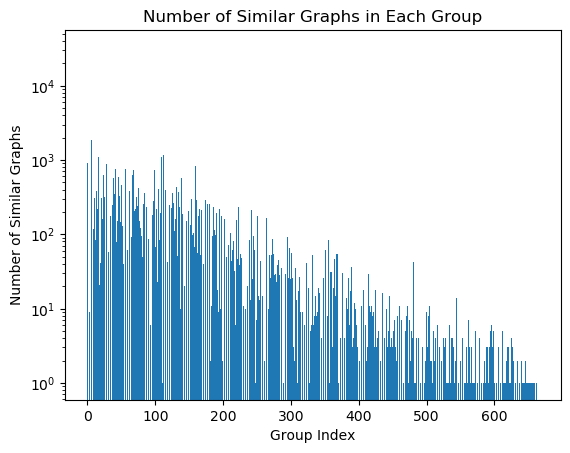

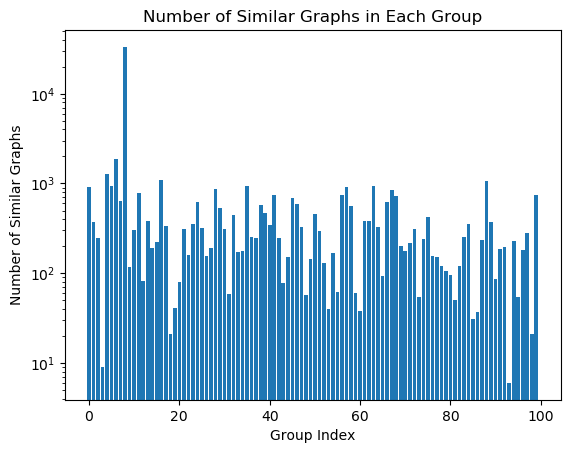

In [6]:
num_similar_graph = [len(group) for group in list_of_same_graphs] 
print("Number of similar graphs for each unique task:", num_similar_graph)

import matplotlib.pyplot as plt
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

num_similar_graph = num_similar_graph[0:100]
plt.bar(range(len(num_similar_graph)), num_similar_graph)
plt.yscale('log')
plt.xlabel('Group Index')
plt.ylabel('Number of Similar Graphs')
plt.title('Number of Similar Graphs in Each Group')
plt.show()

Index of the group with the maximum occurrences: 8


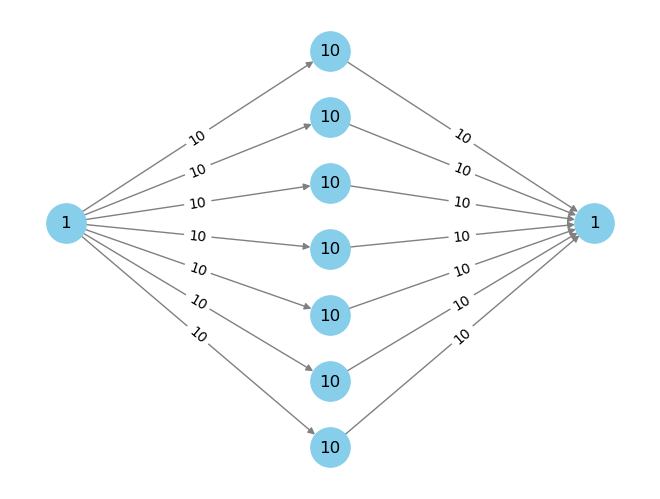

Min: 2665.0, Max: 3613.0
25th Percentile 2676.0
75th Percentile 2962.0
Inter quartile range: 286.0


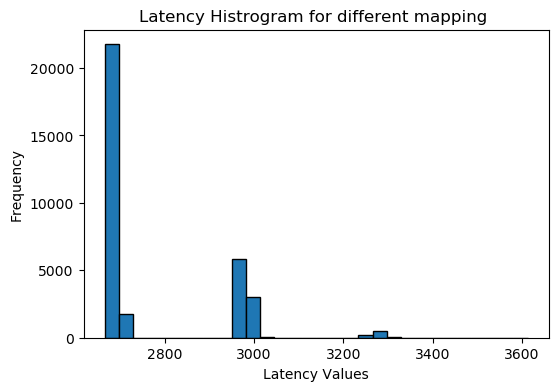

In [7]:
max_occurrences_index = num_similar_graph.index(max(num_similar_graph))
print("Index of the group with the maximum occurrences:", max_occurrences_index)

most_freq_graph_list = list_of_same_graphs[max_occurrences_index]
most_freq_graph_list[0]['task_dag'].plot()

import numpy as np

def plot_latency_histogram(graph_list, fig_width=6, fig_height=4):
    latency_list = []

    for task in graph_list:
        latency = task['network_processing_time']
        latency_list.append(float(latency))

    q1 = np.percentile(latency_list, 25)
    q2 = np.percentile(latency_list, 75)

    print(f"Min: {np.min(latency_list)}, Max: {np.max(latency_list)}")
    print(f"25th Percentile {q1}")
    print(f"75th Percentile {q2}")
    print(f"Inter quartile range: {q2-q1}")

    plt.figure(figsize=(fig_width, fig_height))
    plt.hist(latency_list, bins=30, edgecolor='black')
    plt.title('Latency Histrogram for different mapping ')
    plt.xlabel('Latency Values')
    plt.ylabel('Frequency')
    plt.show()

plot_latency_histogram(most_freq_graph_list)


In [8]:
"""
Creating Training Dataset 
    Make sure, each graph is not occuring more than 1000 time. 
"""

training_dataset = []
for graph_list in list_of_same_graphs:
    for idx, data in enumerate(graph_list):
        if (idx+1) == 1000: break
        training_dataset.append(data)

print(f"Final Size of Training Dataset is {len(training_dataset)}")
print(type(training_dataset[0]))

directory_path = 'data/training_data'

# if not os.path.exists(directory_path):
#     os.makedirs(directory_path)
#     print(f"Directory '{directory_path}' created successfully.")
# else:
#     print(f"Directory '{directory_path}' already exists.")

# for index, data_item in enumerate(training_dataset):
#     file_name = f"data_{index + 1}.pkl"
#     file_path = os.path.join(directory_path, file_name)
#     with open(file_path, 'wb') as file:
#         pickle.dump(data_item, file)
#         print(f"Data saved to '{file_path}' successfully.")

Final Size of Training Dataset is 64288
<class 'dict'>


In [10]:
import torch
from torch_geometric.data import Data
import sys
sys.path.append('../')

# string_to_match = '../'
# sys.path = [path for path in sys.path if string_to_match not in path]
# print(sys.path)

# from gcn.dataset import convert_edge_index

def convert_edge_index(edge_index, num_of_tasks):
    converted_edge_index = []
    node_mapping = {'Start': 0, 'Exit': num_of_tasks}

    for src, dest in edge_index:
        if src == 'Start':
            src = node_mapping[src]

        if dest == 'Exit':
            dest = node_mapping[dest]

        converted_edge_index.append((src, dest))

    return converted_edge_index

def convert_data(data_dict):
    task_dag = data_dict['task_dag']
    task_processing_time = float(data_dict['network_processing_time'])
    target_value = torch.tensor([task_processing_time]).float()

    task_graph = task_dag.graph
    edge_index = list(task_graph.edges)
    
    total_tasks = len(task_graph.nodes)
    last_task = len(task_graph.nodes) - 1
    
    converted_edge_index = convert_edge_index(edge_index, last_task)
    converted_edge_index_torch = torch.tensor(converted_edge_index, dtype=torch.int).t().contiguous()

    dummy_input = torch.ones(total_tasks).view(-1,1)
    data = Data(x=dummy_input,edge_index=converted_edge_index_torch, y=target_value)

    return data

def LatNetInference(data_dict):
    model_path = "../gcn/results/trained_models/LatNet_1100_task.pth"
    model = torch.load(model_path,  map_location=torch.device('cpu'))
    input = convert_data(data_dict)
    pred_latency = model(input)
    actual_latency = input.y
    return pred_latency.item(), actual_latency.item()


test_data =  list_of_same_graphs[0][0]

LatNetInference(test_data)

(1743.83349609375, 1993.0)

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


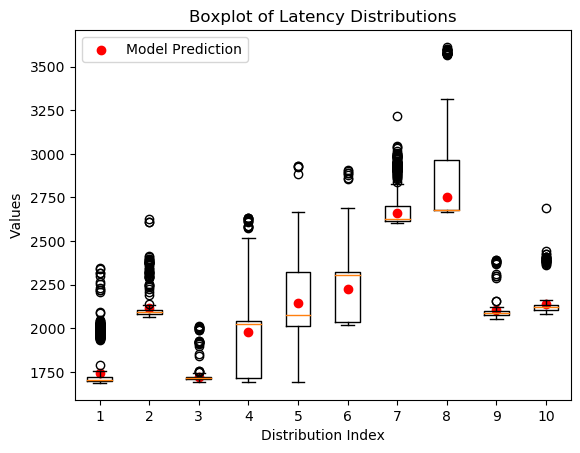

In [11]:
"""
Find Interquartile range ...
    (Difference between 75th percentile and 25th percentile)
... of all the different tasks
"""
interquartile_list = []
median_list = []
all_latency_lists = []
pred_latency_list = []

for idx, similar_graph in enumerate(list_of_same_graphs):
    latency_list = []
    doInference = True

    for map in similar_graph:
        latency_list.append(float(map['network_processing_time']))
        if doInference:
            pred_latency, _ = LatNetInference(map)
            doInference = False

    if len(similar_graph) > 100:
        interquartile_list.append(np.percentile(latency_list, 75) - np.percentile(latency_list, 25))
        median_list.append(np.median(latency_list))
        all_latency_lists.append(latency_list)
        pred_latency_list.append(pred_latency)

    if idx == 10:
        break


# Create the boxplot
fig, ax = plt.subplots()
x_list = np.arange(1, len(all_latency_lists)+1)
ax.boxplot(all_latency_lists, labels=[f'{i}' for i in x_list])
ax.set_title('Boxplot of Latency Distributions')
ax.set_xlabel('Distribution Index')
ax.set_ylabel('Values')

# Create a scatter plot on the same axis
ax.scatter(x_list, pred_latency_list, color='red', marker='o', label='Model Prediction')

ax.legend()

plt.show()